In [55]:
import os
import pickle
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import math
import skimage as ski
import skimage.io

In [56]:
DATA_DIR = './data/'
SAVE_DIR = "./tf_out/"
config = {}
config['max_epochs'] = 8
config['batch_size'] = 50
config['save_dir'] = SAVE_DIR
config['lr_policy'] = {1:{'lr':1e-1}, 3:{'lr':1e-2}, 5:{'lr':1e-3}, 7:{'lr':1e-4}}
config['weight_decay'] = 1e-4

In [134]:
def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

def get_data(data_dir):
    classes_pickle = os.path.join(DATA_DIR, 'batches.meta')
    class_names = np.array(unpickle(classes_pickle)['label_names'])

    img_height = 32
    img_width = 32
    num_channels = 3
    train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
    train_y = []
    for i in range(1, 6):
        subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
        train_x = np.vstack((train_x, subset['data']))
        train_y += subset['labels']
    train_x = train_x.reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1)
    train_y = np.array(train_y, dtype=np.int32)

    subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
    test_x = subset['data'].reshape((-1, num_channels, img_height, img_width)).transpose(0,2,3,1).astype(np.float32)
    test_y = np.array(subset['labels'], dtype=np.int32)
  
    valid_size = 5000
    train_x, train_y = shuffle_data(train_x, train_y)
    valid_x = train_x[:valid_size, ...]
    valid_y = train_y[:valid_size, ...]
    train_x = train_x[valid_size:, ...]
    train_y = train_y[valid_size:, ...]
    data_mean = train_x.mean((0,1,2))
    data_std = train_x.std((0,1,2))

    train_x = (train_x - data_mean) / data_std
    valid_x = (valid_x - data_mean) / data_std
    test_x = (test_x - data_mean) / data_std
    return train_x,valid_x,test_x,train_y,valid_y,test_y,data_mean,data_std,class_names

def variance_scaling_initializer(shape, fan_in, factor=2.0, seed=None):
    sigma = np.sqrt(factor / fan_in)
    return tf.Variable(tf.truncated_normal(shape, stddev=sigma))

In [58]:
def conv2d(x,W,b,strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def max_pool(x, k ,stride):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, stride, stride, 1], padding='SAME')

def fc(x, W, b):
    x =	tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    return tf.nn.relu(tf.add(tf.matmul(x,W),b))

In [59]:
def conv_net(x, weights, biases):
    # CIFAR data input is a  vector of 7168 features (32*32*7 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1,32, 32, 3])

    # Convolution Layer
    conv1 = conv2d(x, weights['w_cv1'], biases['b_cv1'])
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1, k = 3, stride = 2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['w_cv2'], biases['b_cv2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k = 3, stride = 2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = fc(conv2,weights['w_fc1'], biases['b_fc1'])
    fc2 = fc(fc1,weights['w_fc2'], biases['b_fc2'])
    fc3 = tf.reshape(fc2, [-1, weights['out'].get_shape().as_list()[0]])
    fc3 = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    return fc3

In [60]:
def plot_training_progress(save_dir, data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color, linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color, linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color, linewidth=linewidth, linestyle='-', label='validation')
    ax2.legend(loc='upper left', fontsize=legend_size)
    ax3.set_title('Learning rate')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color, linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)

    save_path = os.path.join(save_dir, 'training_plot_2.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)

In [61]:
def evaluate(session, name, x, y, config):
    print("\nRunning evaluation: ", name)
    batch_size = config['batch_size']
    num_examples = x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0
  
    for i in range(num_batches):
        batch_x = x[i*batch_size:(i+1)*batch_size, ...]
        batch_y = y[i*batch_size:(i+1)*batch_size, ...]
        logits_val,loss_val = session.run([logits,reg_loss],feed_dict={X: batch_x, Y_: batch_y})
        yp = np.argmax(logits_val, 1)
        yt = batch_y
        cnt_correct += (yp == yt).sum()
        loss_avg += loss_val
        #print("step %d / %d, loss = %.2f" % (i*batch_size, num_examples, loss_val / batch_size))
    valid_acc = cnt_correct / num_examples * 100
    loss_avg /= num_batches
    print(name + " accuracy = %.2f" % valid_acc)
    print(name + " avg loss = %.2f\n" % loss_avg)
    confusion = confusion_matrix(yt,yp)
    print('Confussion matrix')
    print(confusion)
    print('Recall')
    print(recall_score(yt,yp,average=None))
    print('Accuracy')
    print(accuracy_score(yt,yp))
    return valid_acc,loss_avg

In [62]:
def draw_conv_filters(session, layer, epoch, step, name, save_dir):
    weights = session.run(layer).copy()
    num_filters = weights.shape[3]
    num_channels = weights.shape[2]
    k = weights.shape[0]
    assert weights.shape[0] == weights.shape[1]
    weights -= weights.min()
    weights /= weights.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k,c:c+k,:] = weights[:,:,:,i]
    filename = '%s_epoch_%02d_step_%06d.png' % (name, epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)

In [145]:
train_x,valid_x,test_x,train_y,valid_y,test_y,mean,std,class_names = get_data(DATA_DIR)

num_input = 3072 # MNIST data input (img shape: 32x32)
num_classes = 10

X = tf.placeholder(tf.float32, [None, 32,32,3])
Y_ = tf.placeholder(tf.int32, [None,])
#Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 16 outputs
    'w_cv1': variance_scaling_initializer([5, 5, 3, 16],25*3),
    # 5x5 conv, 16 inputs, 32 outputs
    'w_cv2': variance_scaling_initializer([5, 5, 16, 32],25*16),
    # fully connected, 7*7*32 inputs, 512 outputs
    'w_fc1': variance_scaling_initializer([8*8*32, 256],68*32),
    'w_fc2': variance_scaling_initializer([256,128],256),
    # 512 inputs, 10 outputs (class prediction)
    'out': variance_scaling_initializer([128, num_classes],128)
}
biases = {
    'b_cv1': tf.Variable(tf.zeros([16])),
    'b_cv2': tf.Variable(tf.zeros([32])),
    'b_fc1': tf.Variable(tf.zeros([256])),
    'b_fc2': tf.Variable(tf.zeros([128])),
    'out': tf.Variable(tf.zeros([num_classes]))
}
   
logits = conv_net(X,weights,biases)  
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels =Y_))

reg = 0
for w in [weights['w_cv1'],weights['w_cv2'],weights['w_fc1']]:
    reg += tf.nn.l2_loss(w)

reg_loss = loss + config['weight_decay']*reg

lr = tf.placeholder(tf.float32)
train_step =  tf.train.GradientDescentOptimizer(lr).minimize(reg_loss)	
session = tf.Session()
session.run(tf.initialize_all_variables())
#train(session,train_x,train_y,valid_x,valid_y,config,weights)
#evaluate(session,"Test",test_x,test_y,config)
lr_policy = config['lr_policy']
batch_size = config['batch_size']
num_epochs = config['max_epochs']
save_dir = config['save_dir']
num_examples = train_x.shape[0]
assert num_examples % batch_size == 0
num_batches = num_examples // batch_size


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
plot_data = {}
plot_data['train_loss'] = []
plot_data['valid_loss'] = []
plot_data['train_acc'] = []
plot_data['valid_acc'] = []
plot_data['lr'] = []
for epoch_num in range(1, num_epochs + 1):
    if epoch_num in lr_policy:
        solver_config = lr_policy[epoch_num]
    cnt_correct = 0
    #for i in range(num_batches):
    # shuffle the data at the beggining of each epoch
    permutation_idx = np.random.permutation(num_examples)
    train_x = train_x[permutation_idx]
    train_y = train_y[permutation_idx]
    for step in range(num_batches):
        offset = step * batch_size 

        batch_x = train_x[step*batch_size:(step+1)*batch_size, ...]
        batch_y = train_y[step*batch_size:(step+1)*batch_size, ...]
        start_time = time.time()
        logits_val,loss_val,_ = session.run([logits, reg_loss, train_step] ,feed_dict={X: batch_x, Y_: batch_y, lr:solver_config['lr']})
        yp = np.argmax(logits_val, 1)
        yt = batch_y
        cnt_correct += (yp == yt).sum()
        if step % 5 == 0:
            print("epoch %d, step %d/%d, batch loss = %.2f" % (epoch_num, step*batch_size, num_examples, loss_val))
        if step % 100 == 0:
            draw_conv_filters(session, weights['w_cv1'], epoch_num, step, "conv1", SAVE_DIR)
        if step > 0 and step % 50 == 0:
            print("Train accuracy = %.2f" % (cnt_correct / ((step+1)*batch_size) * 100))
    print("Train accuracy = %.2f" % (cnt_correct / num_examples * 100))   
    train_acc = cnt_correct / num_examples * 100
    train_loss = loss_val
    valid_acc,valid_loss = evaluate(session,"Validation", valid_x, valid_y, config)

    duration = time.time() - start_time

    plot_data['train_loss'] += [train_loss]
    plot_data['valid_loss'] += [valid_loss]
    plot_data['train_acc'] += [train_acc]
    plot_data['valid_acc'] += [valid_acc]
    plot_data['lr'] += [solver_config]
    plot_training_progress(SAVE_DIR, plot_data)

epoch 1, step 0/45000, batch loss = 2.84


C:\Users\Ana\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 250/45000, batch loss = 2.33
epoch 1, step 500/45000, batch loss = 2.32
epoch 1, step 750/45000, batch loss = 2.29
epoch 1, step 1000/45000, batch loss = 2.26
epoch 1, step 1250/45000, batch loss = 2.19
epoch 1, step 1500/45000, batch loss = 2.03
epoch 1, step 1750/45000, batch loss = 2.09
epoch 1, step 2000/45000, batch loss = 2.03
epoch 1, step 2250/45000, batch loss = 2.00
epoch 1, step 2500/45000, batch loss = 2.19
Train accuracy = 19.80
epoch 1, step 2750/45000, batch loss = 2.08
epoch 1, step 3000/45000, batch loss = 2.06
epoch 1, step 3250/45000, batch loss = 2.03
epoch 1, step 3500/45000, batch loss = 1.88
epoch 1, step 3750/45000, batch loss = 2.08
epoch 1, step 4000/45000, batch loss = 1.78
epoch 1, step 4250/45000, batch loss = 1.77
epoch 1, step 4500/45000, batch loss = 1.56
epoch 1, step 4750/45000, batch loss = 1.88
epoch 1, step 5000/45000, batch loss = 1.82
Train accuracy = 25.88
epoch 1, step 5250/45000, batch loss = 1.79
epoch 1, step 5500/45000, batch l

epoch 1, step 44000/45000, batch loss = 1.27
epoch 1, step 44250/45000, batch loss = 1.30
epoch 1, step 44500/45000, batch loss = 1.23
epoch 1, step 44750/45000, batch loss = 1.39
Train accuracy = 44.58

Running evaluation:  Validation
Validation accuracy = 57.54
Validation avg loss = 1.23

Confussion matrix
[[2 0 0 0 0 1 0 0 0 0]
 [0 5 0 0 0 0 1 1 0 0]
 [1 1 0 0 2 3 0 1 0 1]
 [0 0 0 6 0 1 0 1 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 1 0 2 0 0 0 0]
 [0 0 1 1 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 6 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 1 0 0 0 0 0 0 0 2]]
Recall
[ 0.66666667  0.71428571  0.          0.75        1.          0.66666667
  0.5         0.85714286  1.          0.66666667]
Accuracy
0.62
Plotting in:  ./tf_out/training_plot_2.pdf
epoch 2, step 0/45000, batch loss = 1.42
epoch 2, step 250/45000, batch loss = 1.12
epoch 2, step 500/45000, batch loss = 1.44
epoch 2, step 750/45000, batch loss = 1.09
epoch 2, step 1000/45000, batch loss = 1.10
epoch 2, step 1250/45000, batch loss = 1.12
epoch 2, step 

epoch 2, step 40000/45000, batch loss = 1.38
Train accuracy = 59.51
epoch 2, step 40250/45000, batch loss = 1.24
epoch 2, step 40500/45000, batch loss = 1.45
epoch 2, step 40750/45000, batch loss = 1.02
epoch 2, step 41000/45000, batch loss = 0.91
epoch 2, step 41250/45000, batch loss = 1.05
epoch 2, step 41500/45000, batch loss = 1.15
epoch 2, step 41750/45000, batch loss = 1.35
epoch 2, step 42000/45000, batch loss = 1.07
epoch 2, step 42250/45000, batch loss = 0.90
epoch 2, step 42500/45000, batch loss = 1.02
Train accuracy = 59.69
epoch 2, step 42750/45000, batch loss = 1.23
epoch 2, step 43000/45000, batch loss = 1.04
epoch 2, step 43250/45000, batch loss = 1.04
epoch 2, step 43500/45000, batch loss = 1.31
epoch 2, step 43750/45000, batch loss = 1.03
epoch 2, step 44000/45000, batch loss = 1.15
epoch 2, step 44250/45000, batch loss = 1.17
epoch 2, step 44500/45000, batch loss = 1.36
epoch 2, step 44750/45000, batch loss = 1.17
Train accuracy = 59.80

Running evaluation:  Validatio

epoch 3, step 35750/45000, batch loss = 0.71
epoch 3, step 36000/45000, batch loss = 0.86
epoch 3, step 36250/45000, batch loss = 0.63
epoch 3, step 36500/45000, batch loss = 0.91
epoch 3, step 36750/45000, batch loss = 0.62
epoch 3, step 37000/45000, batch loss = 0.91
epoch 3, step 37250/45000, batch loss = 0.83
epoch 3, step 37500/45000, batch loss = 0.62
Train accuracy = 72.48
epoch 3, step 37750/45000, batch loss = 0.64
epoch 3, step 38000/45000, batch loss = 0.74
epoch 3, step 38250/45000, batch loss = 0.79
epoch 3, step 38500/45000, batch loss = 0.66
epoch 3, step 38750/45000, batch loss = 0.63
epoch 3, step 39000/45000, batch loss = 0.85
epoch 3, step 39250/45000, batch loss = 0.83
epoch 3, step 39500/45000, batch loss = 0.83
epoch 3, step 39750/45000, batch loss = 0.76
epoch 3, step 40000/45000, batch loss = 0.65
Train accuracy = 72.54
epoch 3, step 40250/45000, batch loss = 0.72
epoch 3, step 40500/45000, batch loss = 0.86
epoch 3, step 40750/45000, batch loss = 0.81
epoch 3, 

epoch 4, step 31750/45000, batch loss = 0.94
epoch 4, step 32000/45000, batch loss = 1.11
epoch 4, step 32250/45000, batch loss = 0.76
epoch 4, step 32500/45000, batch loss = 0.98
Train accuracy = 75.41
epoch 4, step 32750/45000, batch loss = 0.91
epoch 4, step 33000/45000, batch loss = 0.86
epoch 4, step 33250/45000, batch loss = 0.74
epoch 4, step 33500/45000, batch loss = 0.82
epoch 4, step 33750/45000, batch loss = 0.66
epoch 4, step 34000/45000, batch loss = 0.69
epoch 4, step 34250/45000, batch loss = 0.69
epoch 4, step 34500/45000, batch loss = 0.82
epoch 4, step 34750/45000, batch loss = 0.88
epoch 4, step 35000/45000, batch loss = 0.74
Train accuracy = 75.38
epoch 4, step 35250/45000, batch loss = 0.78
epoch 4, step 35500/45000, batch loss = 0.68
epoch 4, step 35750/45000, batch loss = 0.56
epoch 4, step 36000/45000, batch loss = 0.65
epoch 4, step 36250/45000, batch loss = 0.67
epoch 4, step 36500/45000, batch loss = 0.68
epoch 4, step 36750/45000, batch loss = 0.68
epoch 4, 

epoch 5, step 27750/45000, batch loss = 0.42
epoch 5, step 28000/45000, batch loss = 0.89
epoch 5, step 28250/45000, batch loss = 0.71
epoch 5, step 28500/45000, batch loss = 0.58
epoch 5, step 28750/45000, batch loss = 0.51
epoch 5, step 29000/45000, batch loss = 0.90
epoch 5, step 29250/45000, batch loss = 0.69
epoch 5, step 29500/45000, batch loss = 0.71
epoch 5, step 29750/45000, batch loss = 0.54
epoch 5, step 30000/45000, batch loss = 0.82
Train accuracy = 77.73
epoch 5, step 30250/45000, batch loss = 0.52
epoch 5, step 30500/45000, batch loss = 0.79
epoch 5, step 30750/45000, batch loss = 0.52
epoch 5, step 31000/45000, batch loss = 0.71
epoch 5, step 31250/45000, batch loss = 0.67
epoch 5, step 31500/45000, batch loss = 0.76
epoch 5, step 31750/45000, batch loss = 1.01
epoch 5, step 32000/45000, batch loss = 0.84
epoch 5, step 32250/45000, batch loss = 0.56
epoch 5, step 32500/45000, batch loss = 0.77
Train accuracy = 77.71
epoch 5, step 32750/45000, batch loss = 0.77
epoch 5, 

epoch 6, step 23750/45000, batch loss = 0.47
epoch 6, step 24000/45000, batch loss = 0.75
epoch 6, step 24250/45000, batch loss = 0.79
epoch 6, step 24500/45000, batch loss = 0.52
epoch 6, step 24750/45000, batch loss = 0.68
epoch 6, step 25000/45000, batch loss = 0.72
Train accuracy = 77.68
epoch 6, step 25250/45000, batch loss = 0.60
epoch 6, step 25500/45000, batch loss = 0.72
epoch 6, step 25750/45000, batch loss = 0.68
epoch 6, step 26000/45000, batch loss = 0.60
epoch 6, step 26250/45000, batch loss = 0.54
epoch 6, step 26500/45000, batch loss = 0.93
epoch 6, step 26750/45000, batch loss = 0.55
epoch 6, step 27000/45000, batch loss = 0.81
epoch 6, step 27250/45000, batch loss = 0.76
epoch 6, step 27500/45000, batch loss = 0.66
Train accuracy = 77.70
epoch 6, step 27750/45000, batch loss = 0.77
epoch 6, step 28000/45000, batch loss = 0.66
epoch 6, step 28250/45000, batch loss = 0.55
epoch 6, step 28500/45000, batch loss = 0.97
epoch 6, step 28750/45000, batch loss = 0.66
epoch 6, 

epoch 7, step 19750/45000, batch loss = 0.50
epoch 7, step 20000/45000, batch loss = 0.62
Train accuracy = 77.98
epoch 7, step 20250/45000, batch loss = 0.54
epoch 7, step 20500/45000, batch loss = 0.56
epoch 7, step 20750/45000, batch loss = 0.60
epoch 7, step 21000/45000, batch loss = 0.62
epoch 7, step 21250/45000, batch loss = 0.64
epoch 7, step 21500/45000, batch loss = 0.75
epoch 7, step 21750/45000, batch loss = 0.49
epoch 7, step 22000/45000, batch loss = 0.80
epoch 7, step 22250/45000, batch loss = 0.67
epoch 7, step 22500/45000, batch loss = 0.64
Train accuracy = 78.15
epoch 7, step 22750/45000, batch loss = 0.59
epoch 7, step 23000/45000, batch loss = 0.86
epoch 7, step 23250/45000, batch loss = 0.48
epoch 7, step 23500/45000, batch loss = 0.57
epoch 7, step 23750/45000, batch loss = 0.79
epoch 7, step 24000/45000, batch loss = 0.78
epoch 7, step 24250/45000, batch loss = 0.71
epoch 7, step 24500/45000, batch loss = 0.67
epoch 7, step 24750/45000, batch loss = 0.57
epoch 7, 

epoch 8, step 15500/45000, batch loss = 0.77
epoch 8, step 15750/45000, batch loss = 0.70
epoch 8, step 16000/45000, batch loss = 0.61
epoch 8, step 16250/45000, batch loss = 0.69
epoch 8, step 16500/45000, batch loss = 0.63
epoch 8, step 16750/45000, batch loss = 0.90
epoch 8, step 17000/45000, batch loss = 1.04
epoch 8, step 17250/45000, batch loss = 0.66
epoch 8, step 17500/45000, batch loss = 0.36
Train accuracy = 78.32
epoch 8, step 17750/45000, batch loss = 0.62
epoch 8, step 18000/45000, batch loss = 0.77
epoch 8, step 18250/45000, batch loss = 0.61
epoch 8, step 18500/45000, batch loss = 0.67
epoch 8, step 18750/45000, batch loss = 0.55
epoch 8, step 19000/45000, batch loss = 0.72
epoch 8, step 19250/45000, batch loss = 0.70
epoch 8, step 19500/45000, batch loss = 0.85
epoch 8, step 19750/45000, batch loss = 0.90
epoch 8, step 20000/45000, batch loss = 0.79
Train accuracy = 78.47
epoch 8, step 20250/45000, batch loss = 0.78
epoch 8, step 20500/45000, batch loss = 0.76
epoch 8, 

In [95]:
import skimage as ski
import skimage.io

def draw_image(img, mean, std):
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imshow(img)
    ski.io.show()

In [117]:
outputs = tf.nn.softmax(logits).eval(feed_dict={X: test_x, Y_: test_y}, session=session)
losses = reg_loss.eval(feed_dict={X: test_x, Y_: test_y}, session=session)   

In [146]:
worst = []
for o in range(len(outputs)):
    if (np.argmax(outputs[o])!=test_y[o]):
        worst.append((outputs[o],np.argmax(outputs[o]),test_y[o],test_x[o]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [147]:
worst = worst[-20:]

Predicted class  ship
Correct class  airplane
Classes with max prediction
['ship' 'deer' 'frog']


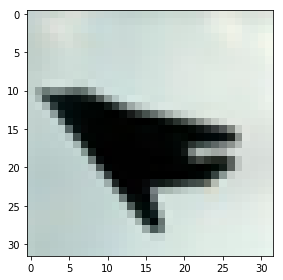

Predicted class  ship
Correct class  deer
Classes with max prediction
['ship' 'frog' 'airplane']


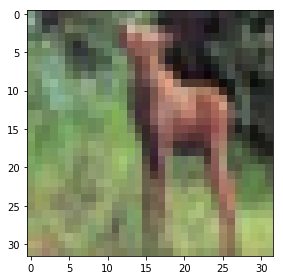

Predicted class  ship
Correct class  bird
Classes with max prediction
['ship' 'frog' 'deer']


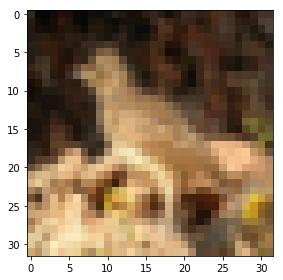

Predicted class  frog
Correct class  airplane
Classes with max prediction
['frog' 'ship' 'deer']


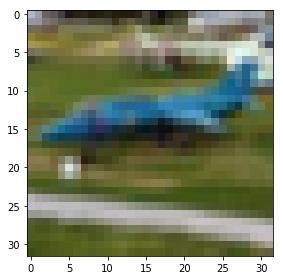

Predicted class  ship
Correct class  horse
Classes with max prediction
['ship' 'airplane' 'frog']


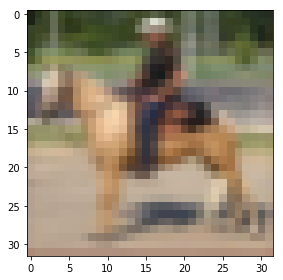

Predicted class  ship
Correct class  dog
Classes with max prediction
['ship' 'frog' 'deer']


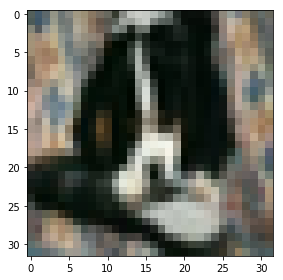

Predicted class  horse
Correct class  ship
Classes with max prediction
['horse' 'deer' 'truck']


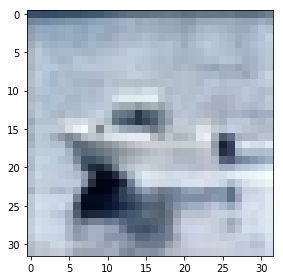

Predicted class  ship
Correct class  airplane
Classes with max prediction
['ship' 'airplane' 'deer']


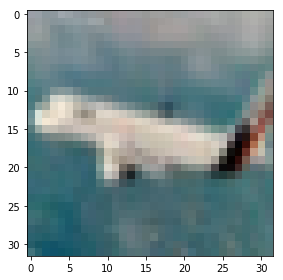

Predicted class  airplane
Correct class  ship
Classes with max prediction
['airplane' 'ship' 'truck']


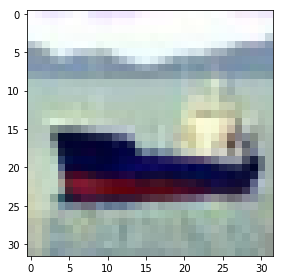

Predicted class  ship
Correct class  bird
Classes with max prediction
['ship' 'airplane' 'deer']


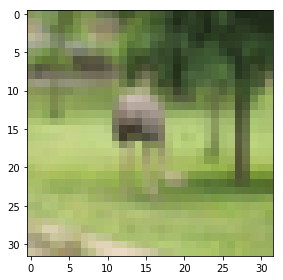

Predicted class  ship
Correct class  horse
Classes with max prediction
['ship' 'frog' 'automobile']


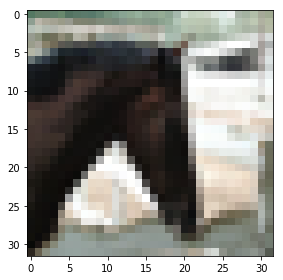

Predicted class  ship
Correct class  airplane
Classes with max prediction
['ship' 'deer' 'automobile']


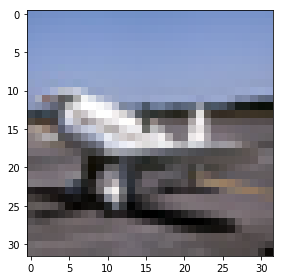

Predicted class  frog
Correct class  cat
Classes with max prediction
['frog' 'truck' 'ship']


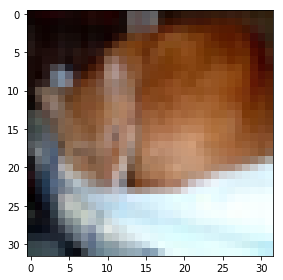

Predicted class  ship
Correct class  dog
Classes with max prediction
['ship' 'airplane' 'deer']


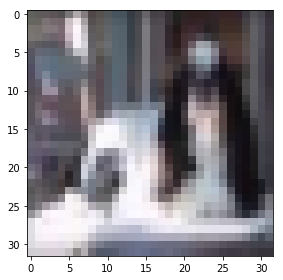

Predicted class  ship
Correct class  cat
Classes with max prediction
['ship' 'deer' 'airplane']


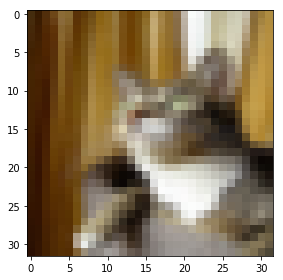

Predicted class  airplane
Correct class  ship
Classes with max prediction
['airplane' 'deer' 'frog']


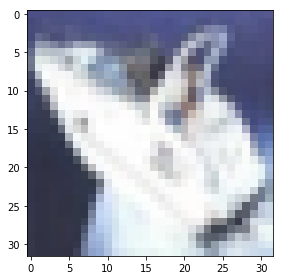

Predicted class  ship
Correct class  cat
Classes with max prediction
['ship' 'frog' 'deer']


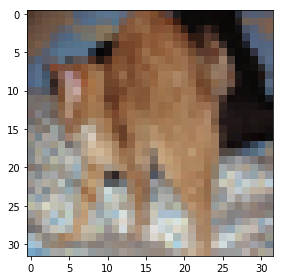

Predicted class  truck
Correct class  dog
Classes with max prediction
['truck' 'ship' 'deer']


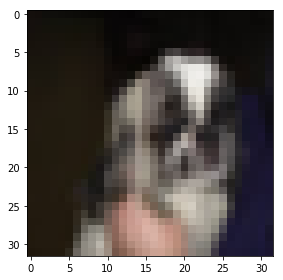

Predicted class  ship
Correct class  automobile
Classes with max prediction
['ship' 'airplane' 'frog']


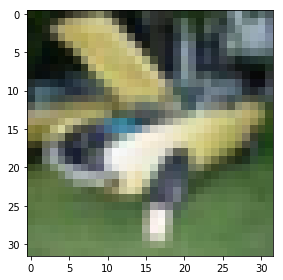

Predicted class  ship
Correct class  horse
Classes with max prediction
['ship' 'airplane' 'deer']


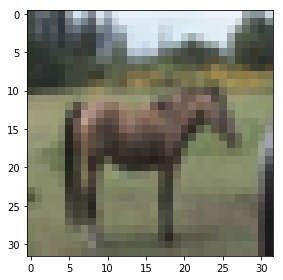

In [148]:
for w in worst:
    print('Predicted class ',class_names[w[1]])
    print('Correct class ',class_names[w[2]])
    print('Classes with max prediction')
    print(class_names[w[0].argsort()[-3:][::-1]])
    draw_image(w[3], mean, std)